# Analyzing Worldwide Box Office Revenue

#### Libraries

In [47]:
import numpy as np
import pandas as pd
pd.set_option("max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download("stopwords")
stop = set(stopwords.words("english"))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data Loading and Exploration

In [48]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [49]:
print(train.shape)
print(test.shape)

(3000, 203)
(4398, 202)


In [50]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

#### Visualizing the Target Distribution (Revenue)

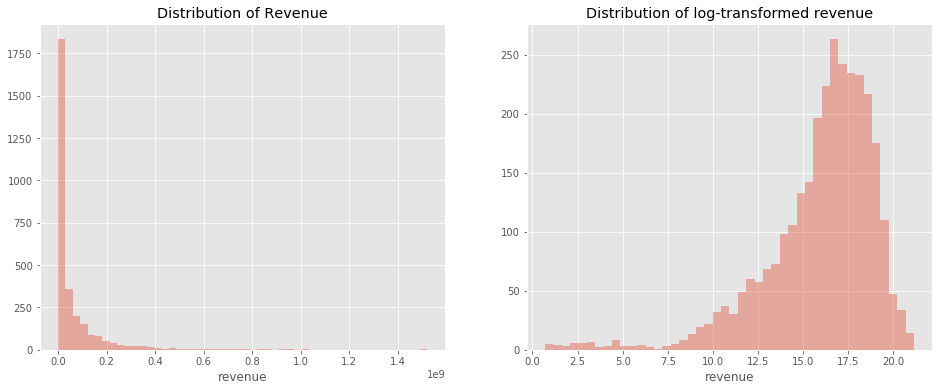

In [51]:
fig, ax = plt.subplots(figsize = (16,6))
plt.subplot(1,2,1)
sns.distplot(train["revenue"], kde = False);
plt.title("Distribution of Revenue");

plt.subplot(1,2,2)
sns.distplot(np.log1p(train["revenue"]), kde = False);
plt.title("Distribution of log-transformed revenue");

In [52]:
train["log_revenue"] = np.log1p(train["revenue"])

#### Relationship between Film Revenue  and Budget

##### assumption - the higher the budget of a film, the more revenue it generates
##### check to see if there is a correlation between the revenue and budget columns

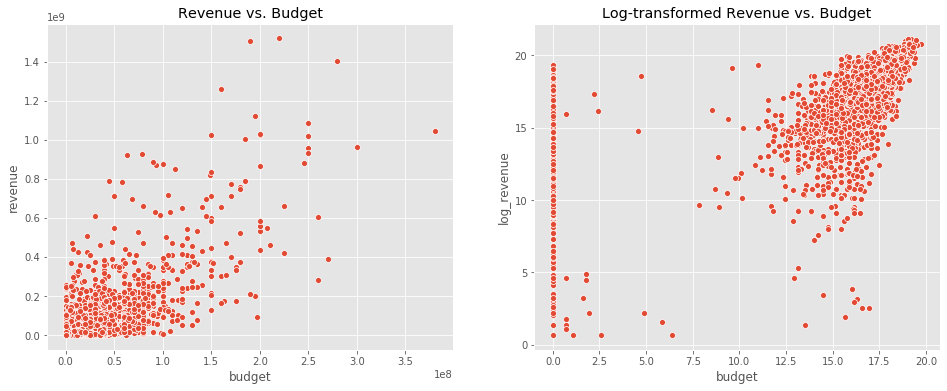

In [53]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
sns.scatterplot(train["budget"], train["revenue"]);
plt.title("Revenue vs. Budget");

plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train["budget"]), train["log_revenue"]);
plt.title("Log-transformed Revenue vs. Budget");

In [54]:
train["log_budget"] = np.log1p(train["budget"])
test["log_budget"] = np.log1p(test["budget"])

#### Does Having an Official Homepage Affect Revenue?

In [55]:
train["homepage"].value_counts().head(10)

http://www.transformersmovie.com/                            4
http://www.thehobbit.com/                                    2
http://www.lordoftherings.net/                               2
http://exmachina-movie.com/                                  1
http://www.dongmakgol2005.co.kr/                             1
http://www.sleepdealer.com/                                  1
http://www.ifcfilms.com/films/the-princess-of-montpensier    1
http://insightthemovie.com/                                  1
http://www.sonypictures.com/homevideo/allthekingsmen/        1
http://theastronautfarmermovie.warnerbros.com/               1
Name: homepage, dtype: int64

In [56]:
# create a binary feature to indicate presence or absence of a homepage
train["has_homepage"] = 0
train.loc[train["homepage"].isnull() == False, "has_homepage"] = 1

test["has_homepage"] = 0
test.loc[test["homepage"].isnull() == False, "has_homepage"] = 1

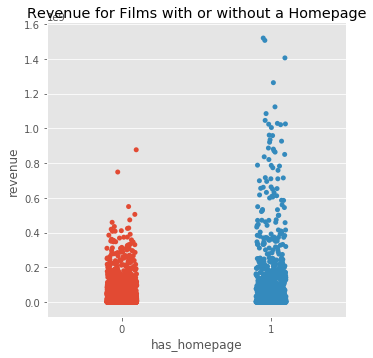

In [57]:
sns.catplot(x="has_homepage", y="revenue", data = train);
plt.title("Revenue for Films with or without a Homepage");

As we can see from the plot above, movies with a homepage tend to generate more revenue. This may not be a causal relationship but having a homepage does have some relation to the amount of revenue a movie generates. This could possibily be due to moviegoers developing interest and learning more  about the movie before deciding to watch it in the cinema.

#### Distribution of Languages in the Film

In [58]:
train["original_language"].value_counts().head(10)

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
Name: original_language, dtype: int64

In [59]:
# select movies that are in the top 10 most frequent original languages
language_data = train.loc[train["original_language"].isin(train["original_language"]
                                                     .value_counts().head(10).index)]

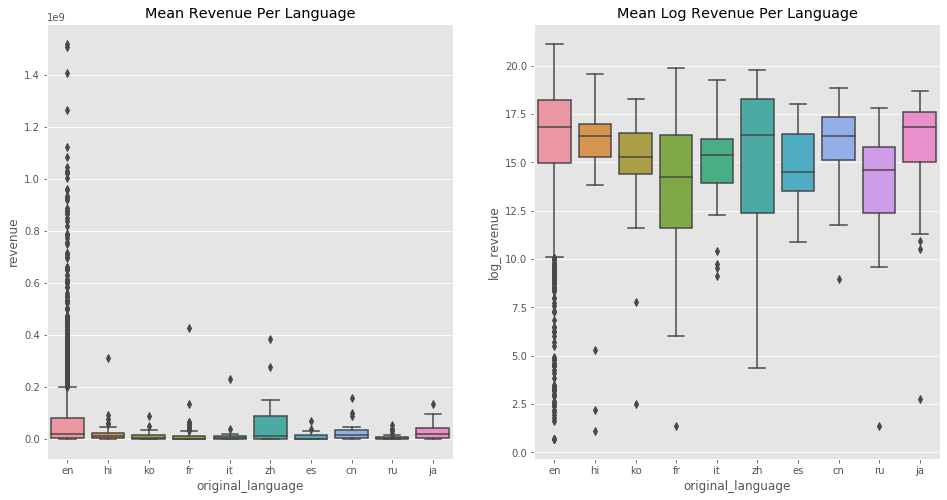

In [60]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.boxplot(x="original_language", y="revenue", data=language_data);
plt.title("Mean Revenue Per Language");
plt.subplot(1,2,2)
sns.boxplot(x="original_language", y="log_revenue", data=language_data);
plt.title("Mean Log Revenue Per Language");

#### Frequent Words in Film Titles and Description

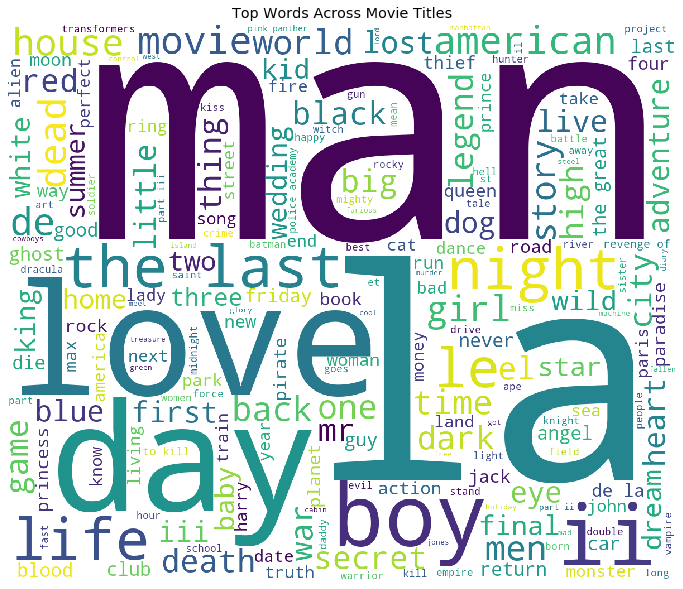

In [61]:
plt.figure(figsize = (12,12))
text = " ".join(train["original_title"].values).lower()
wordcloud = WordCloud(max_font_size = None, background_color = "white",
                     width = 1200, height = 1000).generate(text)

plt.imshow(wordcloud)
plt.title("Top Words Across Movie Titles")
plt.axis("off")
plt.show()

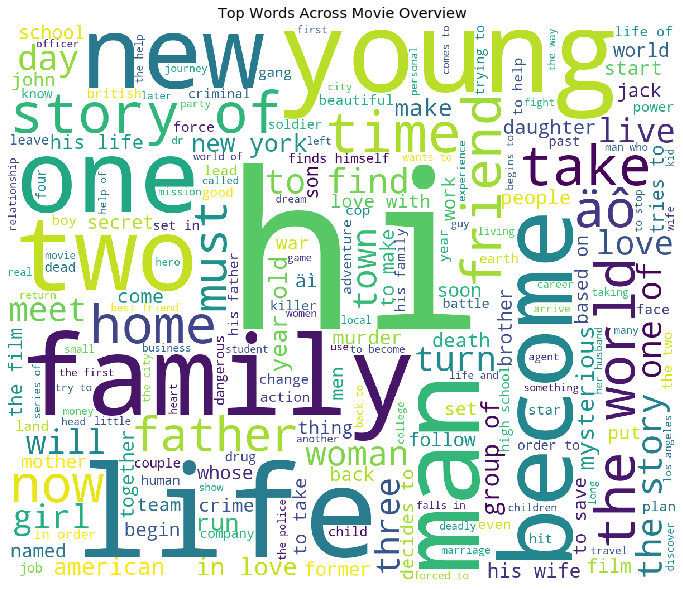

In [62]:
plt.figure(figsize = (12,12))
text = " ".join(train["overview"].fillna("").values).lower()
wordcloud = WordCloud(max_font_size = None, background_color = "white",
                     width = 1200, height = 1000).generate(text)

plt.imshow(wordcloud)
plt.title("Top Words Across Movie Overview")
plt.axis("off")
plt.show()

#### Impact of Film Descriptions on Revenue

In [63]:
import eli5
from sklearn.linear_model import LinearRegression

In [64]:
vectorizer = TfidfVectorizer(sublinear_tf = True, analyzer = "word", stop_words = stop,
                             token_pattern = r'\w{1,}', ngram_range = (1,2), min_df = 5)
#min_df - avoid word frequency of less than 5
#ngram_range - we will be looking into unigrams (single words) 
#and bigrams (pairs of words occuring together))
overview_test = vectorizer.fit_transform(train["overview"].fillna(""))

In [65]:
lr = LinearRegression()
lr.fit(overview_test, train["log_revenue"])
eli5.show_weights(lr, vec=vectorizer, top=20, feature_filter = lambda x: x!= '<BIAS>')

#### Analyzing Movie Release Dates

In [66]:
train.loc[train["release_date"].isnull() == False, "release_date"].head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

In [67]:
def fix_date(x):
    year = x.split("/")[2]
    if int(year) <= 19:
        return x[:-2] + "20" + year
    else:
        return x[:-2] + "19" + year

In [68]:
# finding null values in the release_date column
display(train.loc[train["release_date"].isnull() == True].head())
display(test.loc[test["release_date"].isnull() == True].head())

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_Producer

In [69]:
test.loc[test["release_date"].isnull() == True, "release_date"] = "05/01/00"

In [70]:
# fix release_dates for train and test data sets
train["release_date"] = train["release_date"].apply(lambda x: fix_date(x))
test["release_date"] = test["release_date"].apply(lambda x: fix_date(x))

In [71]:
# convert to datetime object
train["release_date"] = pd.to_datetime(train["release_date"])
test["release_date"] = pd.to_datetime(test["release_date"])

In [74]:
def process_date(df):
    date_types = ["year", "weekday", "month", "weekofyear", "day", "quarter"]
    for date_type in date_types:
        date_col = "release_date" + "_" + date_type
        df[date_col] = getattr(df["release_date"].dt, date_type).astype(int) 
    return df

In [75]:
train = process_date(train)
test = process_date(test)

In [80]:
d1 = train["release_date_year"].value_counts().sort_index()
d2 = test["release_date_year"].value_counts().sort_index()

In [89]:
data = [go.Scatter(x=d1.index, y=d1.values, name="train"),
       go.Scatter(x=d2.index, y=d2.values, name="test")]

layout = go.Layout(dict(title = "Number of films per year", 
                       xaxis = dict(title = "Year"),
                       yaxis = dict(title = "Count"),
                       legend = dict(orientation = "v")))
py.iplot(dict(data=data, layout=layout))

#### Number of Films and Revenue Per Year

In [112]:
d1 = train["release_date_year"].value_counts().sort_index()
d2 = train.groupby("release_date_year")["revenue"].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name="film count"),
       go.Scatter(x=d2.index, y=d2.values, name="total revenue", yaxis = "y2")]

layout = go.Layout(dict(title = "Number of films and total revenue per year", 
                       xaxis = dict(title = "Year"),
                       yaxis = dict(title = "Count"),
                       yaxis2 = dict(title = "total revenue", overlaying = "y", side = "right"),
                       legend = dict(orientation = "v")))
py.iplot(dict(data=data, layout=layout))

In [113]:
d1 = train["release_date_year"].value_counts().sort_index()
d2 = train.groupby("release_date_year")["revenue"].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name="film count"),
       go.Scatter(x=d2.index, y=d2.values, name="mean revenue", yaxis = "y2")]

layout = go.Layout(dict(title = "Number of films and average revenue per year", 
                       xaxis = dict(title = "Year"),
                       yaxis = dict(title = "Count"),
                       yaxis2 = dict(title = "average revenue", overlaying = "y", side = "right"),
                       legend = dict(orientation = "v")))
py.iplot(dict(data=data, layout=layout))

#### Do Release Days Impact Revenue

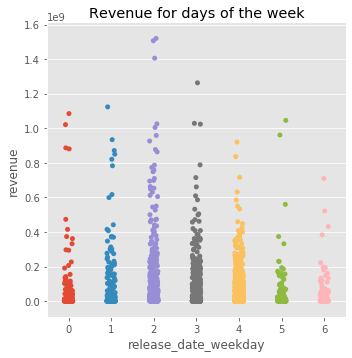

In [114]:
sns.catplot(x="release_date_weekday", y="revenue", data = train)
plt.title("Revenue for different days of the week");

#### Relationship Between Runtime and Revenue

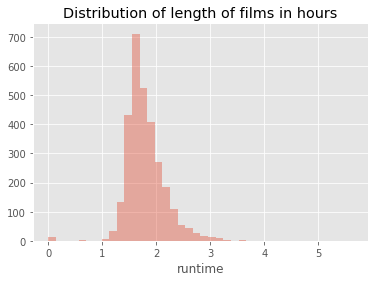

In [116]:
sns.distplot(train["runtime"].fillna(0)/60, bins = 40, kde = False);
plt.title("Distribution of length of films in hours");

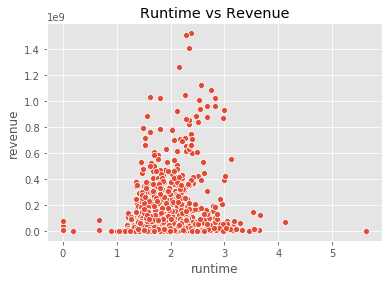

In [119]:
sns.scatterplot(train["runtime"].fillna(0)/60, train["revenue"]);
plt.title("Runtime vs Revenue");